In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

from IPython.display import display

from utils import *

### Load and explore data

In [2]:
data_full = pd.read_csv('data/creditcard.csv')
data_full.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Lets reduce the number of columns to aim in computation. 
# As we saw in the other notebook, it doesn't lead to much of a performance hit
n_dims = 15
cols = list(data_full.columns)[1:] # removes time
cols_reduced = cols[0:n_dims] + cols[-2:]
data = data_full[cols_reduced]

In [4]:
fraudulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

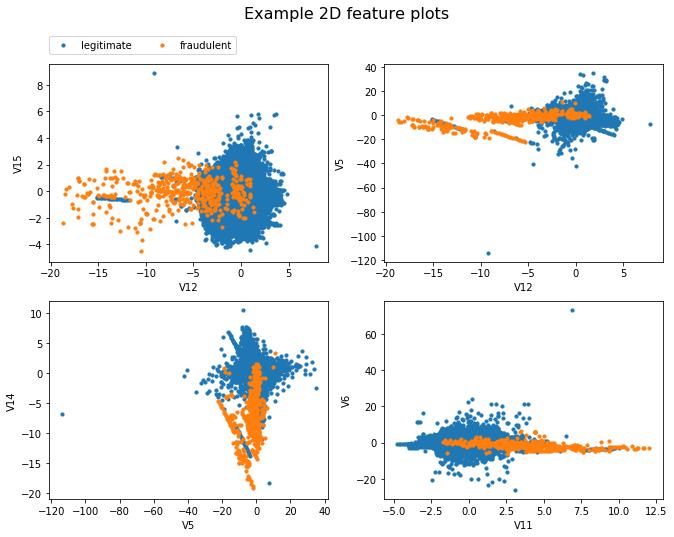

In [5]:
tile_random_features(cols_reduced[:-1], data)

### Prep data

In [6]:
train, test = train_test_split(data, test_size=0.2)

print('% of fraud cases in original, train, and test sets:')
print(len(fraudulent)*1.0/len(data))
print(len(train[train['Class']==1])*1.0/len(train))
print(len(test[test['Class']==1])*1.0/len(test))

% of fraud cases in original, train, and test sets:
0.001727485630620034
0.0017511905023151705
0.0016326673922966188


In [7]:
# Split into features / class labels
X, y = [df.values for df in split_class(data)]
train_x, train_y = [df.values for df in split_class(train)]
test_x, test_y = [df.values for df in split_class(test)]

## Performance Metrics

Note that a dumb majority class classifier has incredible accuracy!

In [8]:
from sklearn.metrics import accuracy_score
bs_pred = np.zeros(test_y.shape)
accuracy_score(test_y, bs_pred)

0.99836733260770338

That's hard to beat!

However what we really care about is not primarily accurancy. We want high recall so that we can find as much fraud ass possible while not creating _too_ many false positives

In [9]:
from sklearn.metrics import recall_score
print("Recall:")
recall_score(test_y, bs_pred)

Recall:


0.0

Recall is quite bad, making this a very poor classifier for finding fraud

Thus we will try to find a sampling methods that has good recall and better-than-horrible precision (or alternatively, high accurancy).

## Sampling methods

We are going to use Logistic Regression because it was the best performing classifiers according to preliminary exploration.

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [37]:
def plot_sampling_method(sampler, cols=(1,3), minority_only=False, marker='+'):
    x_resampled, y_resampled = sampler.fit_sample(train_x, train_y)
    majority = x_resampled[y_resampled == 0]
    minorty = x_resampled[y_resampled == 1]
    
    col_names = data.columns

    stack_vert = False
    size = [5,10]
    fig_args = [2,1] 

    if not stack_vert:
        size = size[::-1]
        fig_args = fig_args[::-1]

    fig_kwargs = {'sharex':stack_vert, 'sharey':(not stack_vert), 'figsize':size}
    fig, axarr = plt.subplots(*fig_args, **fig_kwargs)
    ax_orig = axarr[0]
    ax_rs = axarr[1]

    if not minority_only:
        line0 = ax_orig.scatter(legit[col_names[cols[0]]], legit[col_names[cols[1]]], marker=marker)
        ax_rs.scatter(majority[:,cols[0]], majority[:,cols[1]], marker=marker)
        
    line1 = ax_orig.scatter(fraudulent[col_names[cols[0]]], fraudulent[col_names[cols[1]]], marker=marker)
    ax_orig.set_title('Original data')
    ax_orig.set_ylabel(col_names[cols[0]])
    ax_orig.set_xlabel(col_names[cols[1]])

    line1_rs = ax_rs.scatter(minorty[:,cols[0]], minorty[:,cols[1]], marker=marker)
    ax_rs.set_title(type(sampler).__name__)
    ax_rs.set_xlabel(col_names[cols[1]])
    
    if not minority_only:
        ax_orig.legend((line0, line1), ('majority', 'minority'))
    else:
        line1.set_color(plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
        line1_rs.set_color(plt.rcParams['axes.prop_cycle'].by_key()['color'][1])

    plt.show()
    

def plot_pr_model_group(group):
    labels, models = [list(x) for x in zip(*group.models.items())]
    plot_many_pr(models, labels, test_x, test_y)#, title=get_class_name(group.models['Baseline']))

In [12]:
from collections import OrderedDict

def agg_scores(scores_dict):
    return {n.split('_')[1]:vals.mean() for n,vals in scores_dict.items() if 'train' not in n}


def build_score_df(scores, labels):
    metrics = pd.DataFrame(index=labels)
    agg = [agg_scores(s) for s in scores]
    
    metrics['f1']        = [a['f1'] for a in agg]
    metrics['recall']    = [a['recall'] for a in agg]
    metrics['geometric'] = [a['geometric'] for a in agg]

    return metrics


class ModelGroup:
    
    def __init__(self, cv=5):
        self.models = OrderedDict()
        self.scores = OrderedDict()
#         self.labels = []
        self.cv = cv
    
    def record_model(self, label, model, sampler=None, **kwargs):
        """
        Keep track of our models for comparison later. 
        Scores are results of kfold cv, while the models are trained on a single train set.
        """
        if sampler is not None:
            cv_scores = cv_sampler(sampler, model, X, y, cv=self.cv, **kwargs) # see utils
            train_x_res, train_y_res = sampler.fit_sample(train_x, train_y)
            self.models[label] = model.fit(train_x_res, train_y_res)
        else: 
            cv_scores = test_model(model ,X, y, cv=self.cv, **kwargs)
            self.models[label] = model.fit(train_x, train_y)

        self.scores[label] = cv_scores

    def to_score_df(self):
        labels, scores = [list(x) for x in zip(*self.scores.items())]
        return build_score_df(scores, labels)

### Baseline

Note: for all models we will train on a single train/test split because CV is complicated by the sampling techniques.

In [13]:
print_class_counts(train_y)

Class counts:
[(0, 227446), (1, 399)]


### Over sampling

Class counts:
[(0, 227446), (1, 227446)]


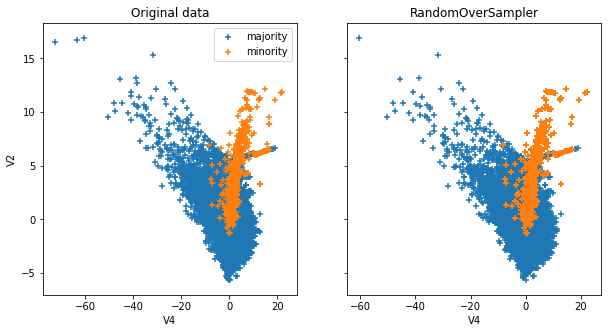

In [14]:
from imblearn.over_sampling import RandomOverSampler
train_x_res, train_y_res = RandomOverSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)
plot_sampling_method(RandomOverSampler())

Doesn't look different because new points are duplicates of old points.

### Under sampling

Class counts:
[(0, 399), (1, 399)]


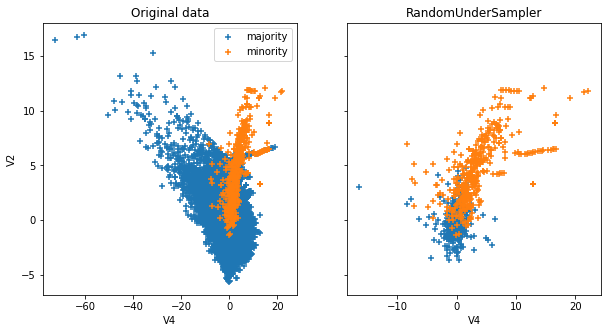

In [15]:
from imblearn.under_sampling import RandomUnderSampler
train_x_res, train_y_res = RandomUnderSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)
plot_sampling_method(RandomUnderSampler())

### SMOTE/ADASYN oversampling

In [16]:
from imblearn.over_sampling import SMOTE, ADASYN
train_x_res, train_y_res = SMOTE().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227446), (1, 227446)]


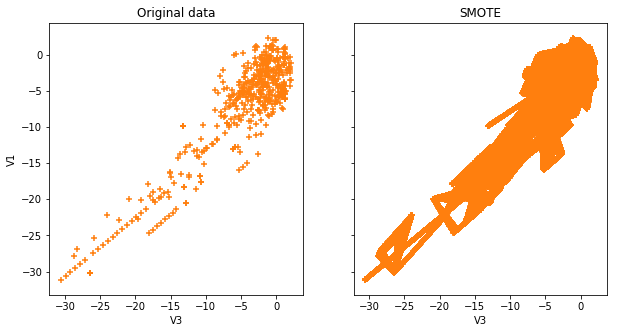

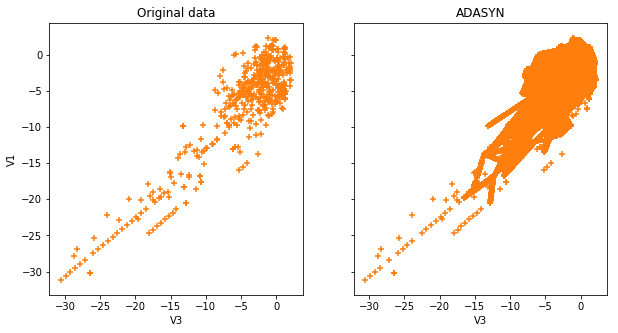

In [17]:
plot_sampling_method(SMOTE(), minority_only=True, cols=(0,2))
plot_sampling_method(ADASYN(), minority_only=True, cols=(0,2))

### Logistic regression performance

In [18]:
logit = ModelGroup(cv=5)

In [19]:
logit.record_model('Baseline', LogisticRegression())

---LogisticRegression---
Precision: 	0.86
Recall: 	0.61
F1: 		0.69
Geometric mean: 0.77


In [20]:
logit.record_model('Oversampling', LogisticRegression(), RandomOverSampler())

---LogisticRegression---
Precision: 	0.06
Recall: 	0.88
F1: 		0.11
Geometric mean: 0.93


In [21]:
logit.record_model('Undersampling', LogisticRegression(), RandomUnderSampler())

---LogisticRegression---
Precision: 	0.05
Recall: 	0.90
F1: 		0.09
Geometric mean: 0.93


In [22]:
logit.record_model('SMOTE', LogisticRegression(), SMOTE())

---LogisticRegression---
Precision: 	0.07
Recall: 	0.89
F1: 		0.13
Geometric mean: 0.93


In [23]:
logit.record_model('ADASYN', LogisticRegression(), ADASYN())

---LogisticRegression---
Precision: 	0.03
Recall: 	0.91
F1: 		0.07
Geometric mean: 0.93


#### Model weights

Balanced is using the built-in class weights using the 'balanced', and weighted is my chosen class weights.

In [24]:
logit.record_model('Balanced', LogisticRegression(class_weight='balanced'))

---LogisticRegression---
Precision: 	0.06
Recall: 	0.88
F1: 		0.10
Geometric mean: 0.93


In [25]:
logit.record_model('Weighted', LogisticRegression(class_weight={0:1,1:100}))

---LogisticRegression---
Precision: 	0.23
Recall: 	0.86
F1: 		0.36
Geometric mean: 0.92


###  Ranking Performance

In [26]:
labels, models = [list(x) for x in zip(*logit.models.items())]
metrics = logit.to_score_df()
metrics

,f1,recall,geometric
Baseline,0.691942,0.607174,0.772840
Oversampling,0.111095,0.881897,0.927223
Undersampling,0.090395,0.896072,0.930150
SMOTE,0.131978,0.889853,0.933245
ADASYN,0.065342,0.908211,0.930221
Balanced,0.103994,0.884168,0.926883
Weighted,0.356138,0.857658,0.923368


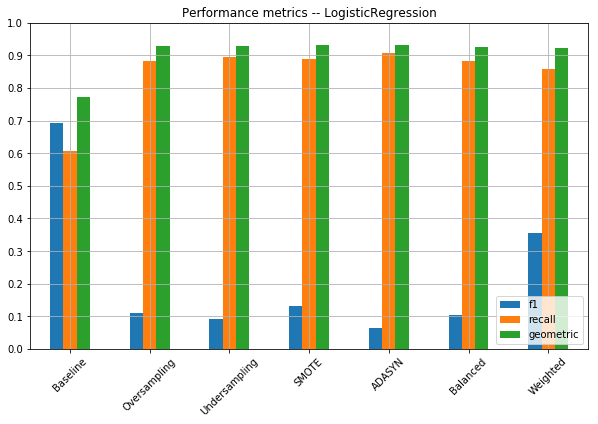

In [27]:
bar_plot(metrics, get_class_name(models[0]))

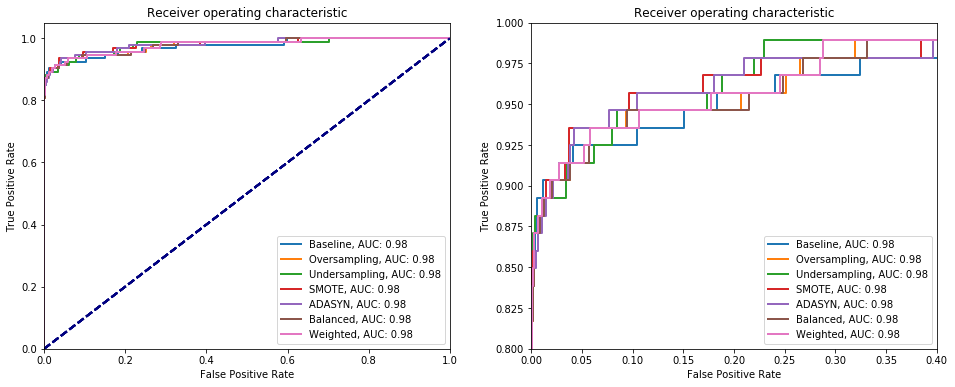

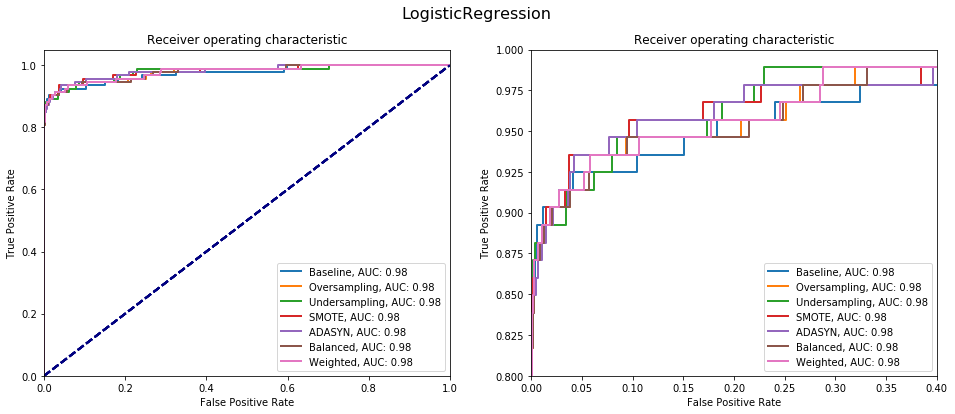

In [43]:
plot_many_roc(models, labels, test_x, test_y)

All the methods solidly outperform the baseline, though for the most part their performance is hard to distinguish from each other here. 

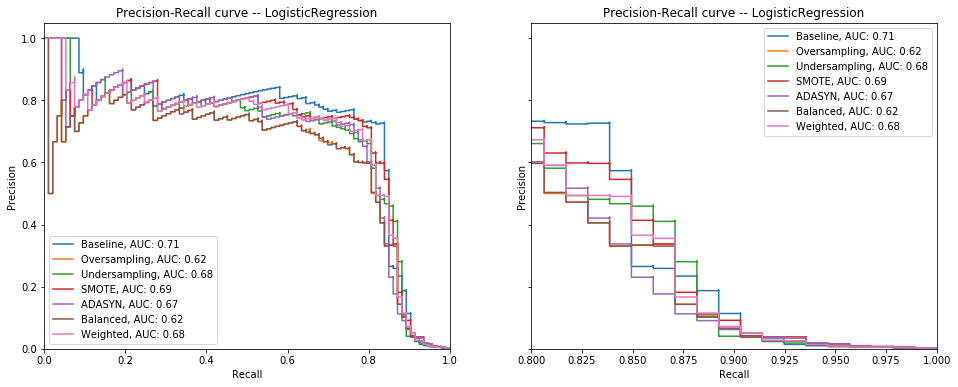

In [29]:
plot_pr_model_group(logit)

All models have similar AUC scores, except for a low score from undersampling. Many seem to perform similarly in the high-recall/low precision region. Since this is the only region we really care about ROC plots don't appear to be hugely useful. However if you look at the right figure (or squint pretty hard) you can see that baseline does a little worse in that region.

### Now for the SVC and Random Forest classifiers

In [30]:
def build_model_group(model, weighted_model=None):
    model_group = ModelGroup(cv=5)
    
    print('Baseline')
    model_group.record_model('Baseline', model, verbose=False)
    print('Sampling methods')
    model_group.record_model('Oversampling', model, RandomOverSampler(), verbose=False)
    model_group.record_model('Undersampling', model, RandomUnderSampler(), verbose=False)
    print('Synthetic methods')
    model_group.record_model('SMOTE', model, SMOTE(), verbose=False)
    model_group.record_model('ADASYN', model, ADASYN(), verbose=False)
    
    # Weighted classes are optional
    if weighted_model is not None:
        print('Weighted')
        model_group.record_model('Weighted', weighted_model, verbose=False)
    
    return model_group


In [31]:
model_groups = {}
model_groups['logit'] = logit
print('SVC...')
model_groups['svc']  = build_model_group(LinearSVC(dual=False), 
                                           LinearSVC(dual=False, class_weight={0:1,1:100}))
print('\nSVC done, do RF..')
model_groups['forest']  = build_model_group(RandomForestClassifier(criterion='entropy'),
                                        RandomForestClassifier(criterion='entropy', class_weight={0:1,1:100}))

SVC...
Baseline
Sampling methods
Synthetic methods
Weighted

SVC done, do RF..
Baseline
Sampling methods
Synthetic methods
Weighted


Collect metrics into dataframes and plot

In [38]:
metrics_groups = {name: group.to_score_df() for (name,group) in model_groups.items()}
metrics_groups.keys()

dict_keys(['logit', 'svc', 'forest'])

In [39]:
metrics_groups['svc']

,f1,recall,geometric
Baseline,0.662662,0.552216,0.734056
Oversampling,0.135732,0.879662,0.928573
Undersampling,0.101094,0.881055,0.925397
SMOTE,0.154246,0.888172,0.934059
ADASYN,0.075741,0.910759,0.934619
Weighted,0.501331,0.855556,0.923298


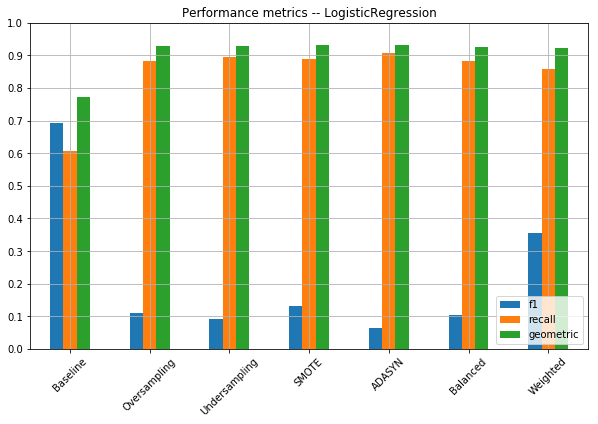

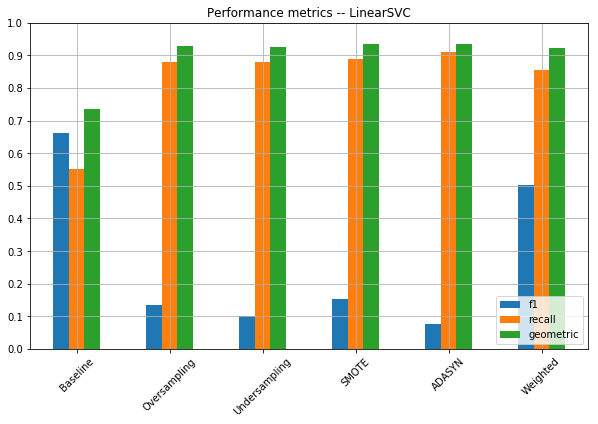

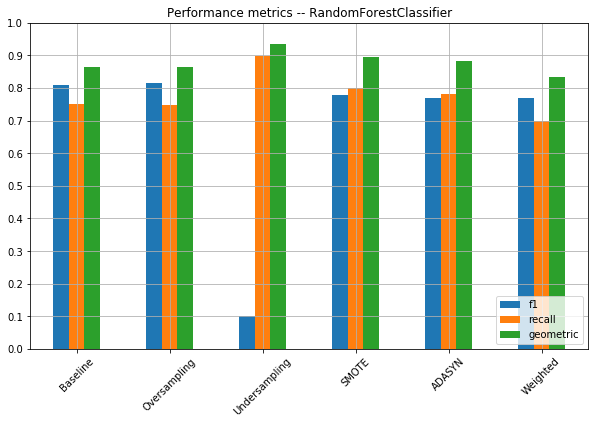

In [40]:
class_name = lambda group_name: get_class_name(model_groups[group_name].models['Baseline'])
bar_plot(metrics_groups['logit'], class_name('logit'))
bar_plot(metrics_groups['svc'], class_name('svc'))
bar_plot(metrics_groups['forest'], class_name('forest'))

#### Precision Recall

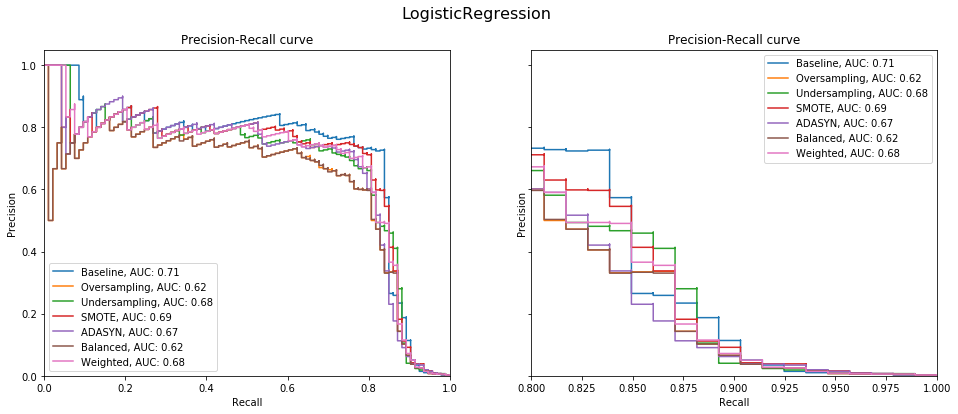

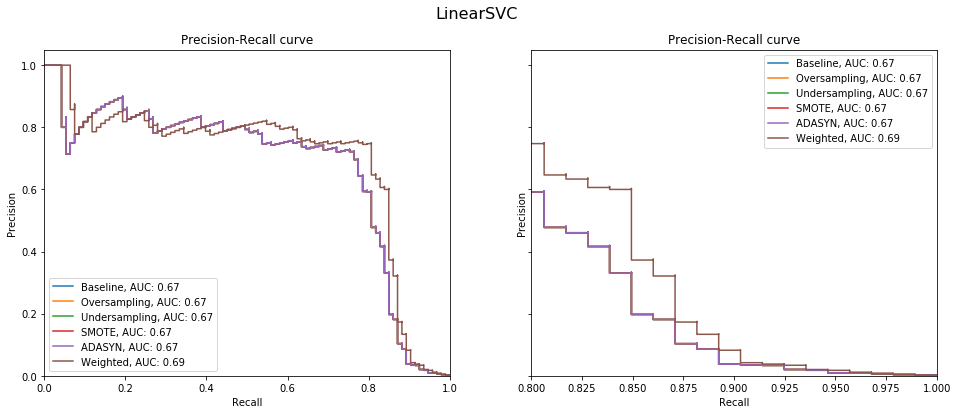

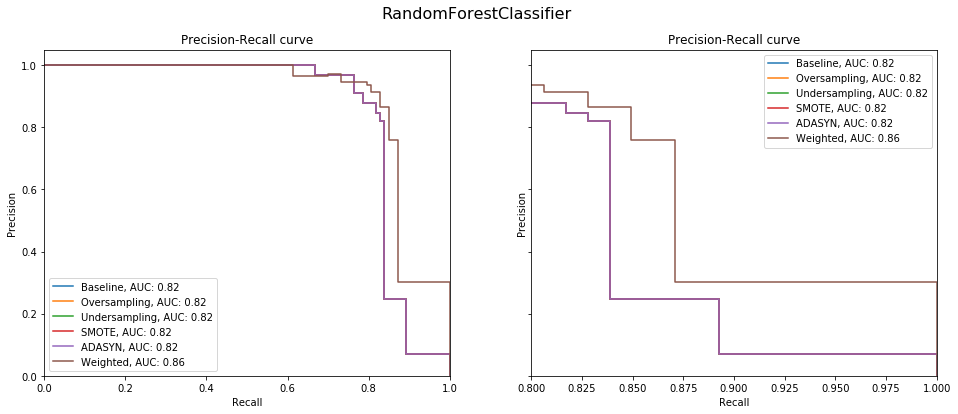

In [41]:
plot_pr_model_group(model_groups['logit'])
plot_pr_model_group(model_groups['svc'])
plot_pr_model_group(model_groups['forest'])

Again, PR curves don't seem super helpful for us, since we don't care nearly as much about precision as we do recall, and all of the curves are very close together. Better to use the bar plots above with our metrics of choice.

#### Conclusion